# Using ESMF LocStream objects

LocStream objects are describing a list of geographical points. Using a LocStream object can significantly reduce computational time. It is particularly useful when remapping gridded output (e.g. model) onto observation locations, or to generate open boundary conditions. Note that it is also possible to remap from LocStream to grid, which can be useful for some application (e.g. [supersampling](https://en.wikipedia.org/wiki/Supersampling))  

In [1]:
import xarray as xr
import xesmf as xe

## Remapping from a grid to a LocStream

Let's open a gridded dataset (for example the xarray air temperature dataset):

In [2]:
airtemps = xr.tutorial.open_dataset('air_temperature')

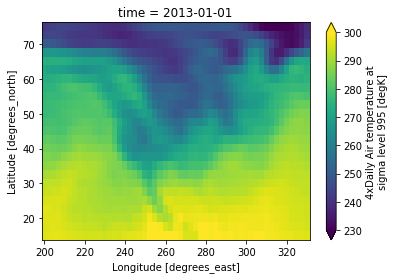

In [3]:
airtemps['air'].isel(time=0).plot(vmin=230, vmax=300)

Now let's define a list of geographical points. xESMF requires a xarray.Dataset as input format.
Here I created it manually but this can be read from a csv file using pandas and exported into a xarray.Dataset. The name of the dimension used for the LocStream is not important.

In [4]:
ds_locs = xr.Dataset()
ds_locs['lon'] = xr.DataArray(data=[220,230,240,250,260,270], dims=('location'))
ds_locs['lat'] = xr.DataArray(data=[20,30,40,50,60,70], dims=('locations'))

Creating a Regridder to remap to a LocStream object is done in a similar way than grid to grid, except:
- set the optional argument **locstream_out** to **True**
- conservative method is **not** available

In [5]:
regrid = xe.Regridder(airtemps, ds_locs, 'bilinear', locstream_out=True)

Create weight file: bilinear_25x53_1x6.nc


In [6]:
airtemps_locs = regrid(airtemps)

using dimensions ('lat', 'lon') from data variable air as the horizontal dimensions for this dataset.


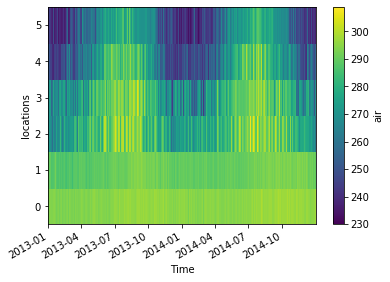

In [7]:
airtemps_locs['air'].plot(x='time')

## Remapping from LocStream to grid

The opposite transformation is possible, but with more restrictive interpolation methods:
- only available methods are **nearest_s2d** and **nearest_d2s**
- activate using **locstream_in** to **True**

In [8]:
regrid_back_s2d = xe.Regridder(airtemps_locs, airtemps, 'nearest_s2d', locstream_in=True)

Create weight file: nearest_s2d_1x6_25x53.nc


In [9]:
airtemps_locs

<xarray.Dataset>
Dimensions:  (locations: 6, time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
    lon      (locations) int64 220 230 240 250 260 270
    lat      (locations) int64 20 30 40 50 60 70
Dimensions without coordinates: locations
Data variables:
    air      (time, locations) float64 292.8 288.9 268.1 ... 268.4 255.5 236.8
Attributes:
    regrid_method:  bilinear

In [10]:
airtemps_gridded2 = regrid_back_s2d(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


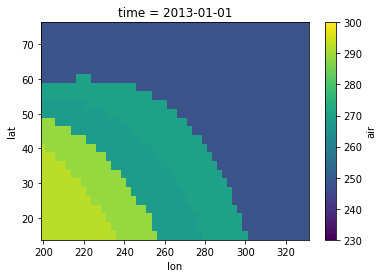

In [11]:
airtemps_gridded2['air'].isel(time=0).plot(vmin=230, vmax=300)

Since we drastically undersampled the original dataset, the reconstruction is very different
from the original. The other nearest-neighbor option (d2s) will only map one destination grid point per LocStream point: 

In [12]:
regrid_back_d2s = xe.Regridder(airtemps_locs, airtemps, 'nearest_d2s', locstream_in=True)

Create weight file: nearest_d2s_1x6_25x53.nc


In [13]:
airtemps_gridded3 = regrid_back_d2s(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


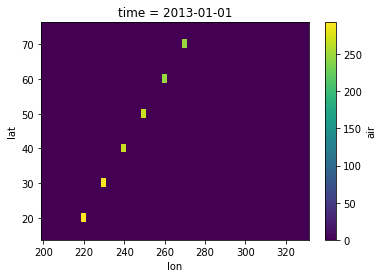

In [14]:
airtemps_gridded3['air'].isel(time=0).plot()

## LocStream to LocStream

It is also possible to remap from one LocStream to another, again only nearest neighbor methods are available.

In [15]:
ds_locs2 = xr.Dataset()
ds_locs2['lon'] = xr.DataArray(data=[225,235,245,255,265,275], dims=('location'))
ds_locs2['lat'] = xr.DataArray(data=[20,30,40,50,60,70], dims=('locations'))

In [16]:
regrid_l2l = xe.Regridder(ds_locs, ds_locs2, 'nearest_s2d',
                          locstream_in=True, locstream_out=True)

Create weight file: nearest_s2d_1x6_1x6.nc


In [17]:
airtemps_locs2 = regrid_l2l(airtemps_locs)

using dimensions ('locations',) from data variable air as the horizontal dimensions for this dataset.


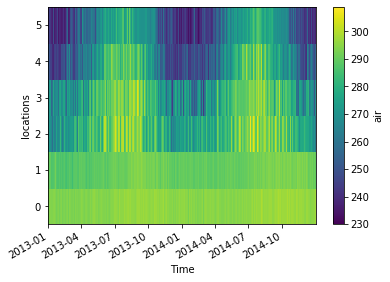

In [18]:
airtemps_locs2['air'].plot(x='time')